In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from scipy.optimize import curve_fit

## 1. Load Benchmark Data
- Read all `results/*.csv` files into `pandas` DataFrames

In [2]:
!ls "./results"

dot_product.csv   matrix_mult.csv   pi_estimation.csv quick_sort.csv
image_blur.csv    merge_sort.csv    prefix_sum.csv


In [3]:
# Define both result paths
openmp_path = "./results"
rust_path = "./rust_proj/results"

# Define benchmark base names
benchmark_names = [
    "dot_product", "image_blur", "matrix_mult", "pi_estimation",
    "prefix_sum", "quick_sort", "merge_sort"
]

# Load all OpenMP results
openmp_results = {}
for name in benchmark_names:
    filepath = os.path.join(openmp_path, f"{name}.csv")
    df = pd.read_csv(filepath)
    
    # Convert 'Time' or 'Time (s)' column to milliseconds
    for col in df.columns:
        if "Time" in col and "(s)" in col:
            df[col] = df[col] * 1000
            df.rename(columns={col: col.replace("(s)", "(ms)")}, inplace=True)

    openmp_results[name] = df

# Load all Rust results
rust_results = {}
for name in benchmark_names:
    filepath = os.path.join(rust_path, f"{name}_rust.csv")
    rust_results[name] = pd.read_csv(filepath)

In [4]:
# Loop through each benchmark's Rust result
for name, df in rust_results.items():
    time_col = next((col for col in df.columns if "Time" in col), None)
    if time_col:
        new_times = []
        for val in df[time_col]:
            if val < 10:  # heuristic: if very low, probably in seconds
                new_times.append(val * 1000)  # convert to ms
            else:
                new_times.append(val)  # already in ms
        df[time_col] = new_times
        df.rename(columns={time_col: "Time (ms)"}, inplace=True)

In [5]:
for name in benchmark_names:
    print(name)
    print(openmp_results[name].head())
    print(rust_results[name].head())
    print("")

dot_product
   Threads  Time (ms)  Dot Product
0        1    378.277   16777216.0
1        2    251.706   20969164.0
2        4    155.207   23631394.0
3        8    131.793   24579896.0
4       16    108.708   24874172.0
   Threads   Time (ms)     Result
0        1  375.557047  100000000
1        2  223.732525  100000000
2        4  164.880838  100000000
3        8  117.367505  100000000
4       16   92.594435  100000000

image_blur
   Threads  Time (ms) Correctness
0        1   1152.866     Correct
1        2    605.302     Correct
2        4    314.942     Correct
3        8    252.947     Correct
4       16    194.328     Correct
   Threads    Time (ms)  Result
0        1  2954.227000     NaN
1        2  1517.958000     NaN
2        4   797.550888     NaN
3        8   559.759823     NaN
4       16   362.453798     NaN

matrix_mult
   Threads  Time (ms)
0        1   4136.051
1        2   2314.669
2        4   1398.697
3        8    954.454
4       16    627.427
   Threads  Time (ms)

## 2. Plot Raw Times
- Time vs Threads plots per benchmark
- Bar chart of Best Time per language

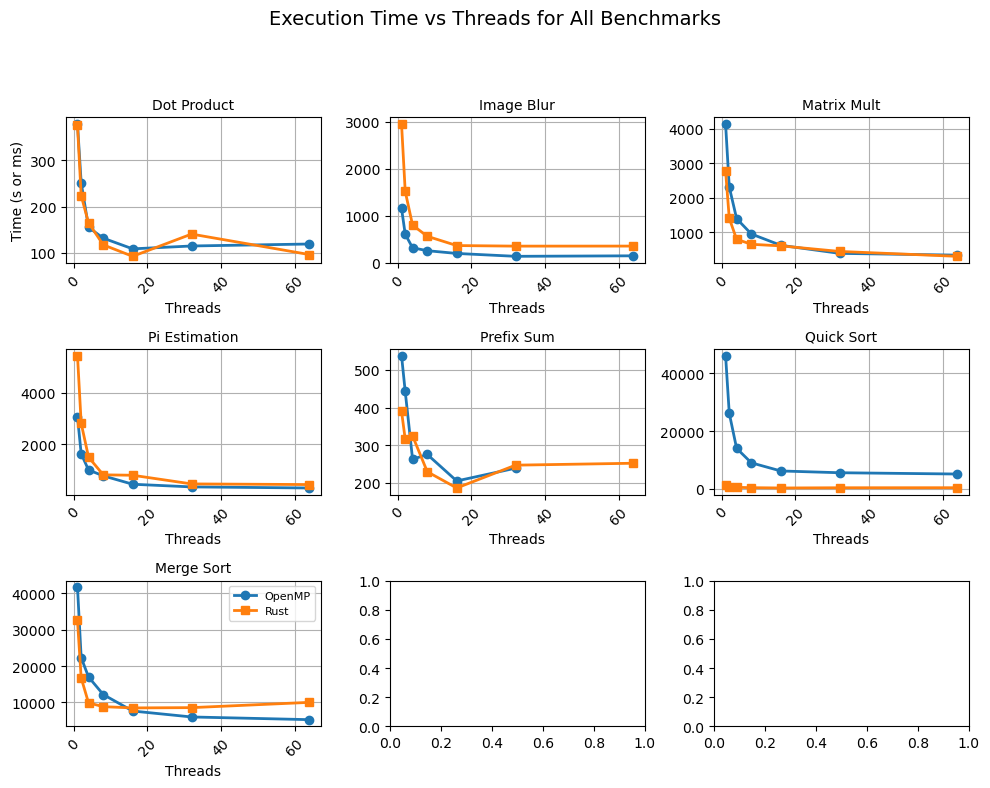

In [6]:
# --- Subplots for Time vs Threads ---
num_benchmarks = len(benchmark_names)
# 3 rows x 3 columns grid
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8), sharey=False)
axes = axes.flatten()

for i, name in enumerate(benchmark_names):
    if name in openmp_results and name in rust_results:
        df_openmp = openmp_results[name]
        df_rust = rust_results[name]

        omp_x = df_openmp.iloc[:, 0]
        omp_y = df_openmp.iloc[:, 1]
        rust_x = df_rust.iloc[:, 0]
        rust_y = df_rust.iloc[:, 1]

        ax = axes[i]
        ax.plot(omp_x, omp_y, marker='o', label='OpenMP', linewidth=2)
        ax.plot(rust_x, rust_y, marker='s', label='Rust', linewidth=2)
        ax.set_title(name.replace("_", " ").title(), fontsize=10)
        ax.set_xlabel('Threads')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)
        if i == 0:
            ax.set_ylabel('Time (s or ms)')
        if i == len(benchmark_names) - 1:
            ax.legend(loc='upper right', fontsize=8)

plt.suptitle("Execution Time vs Threads for All Benchmarks", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

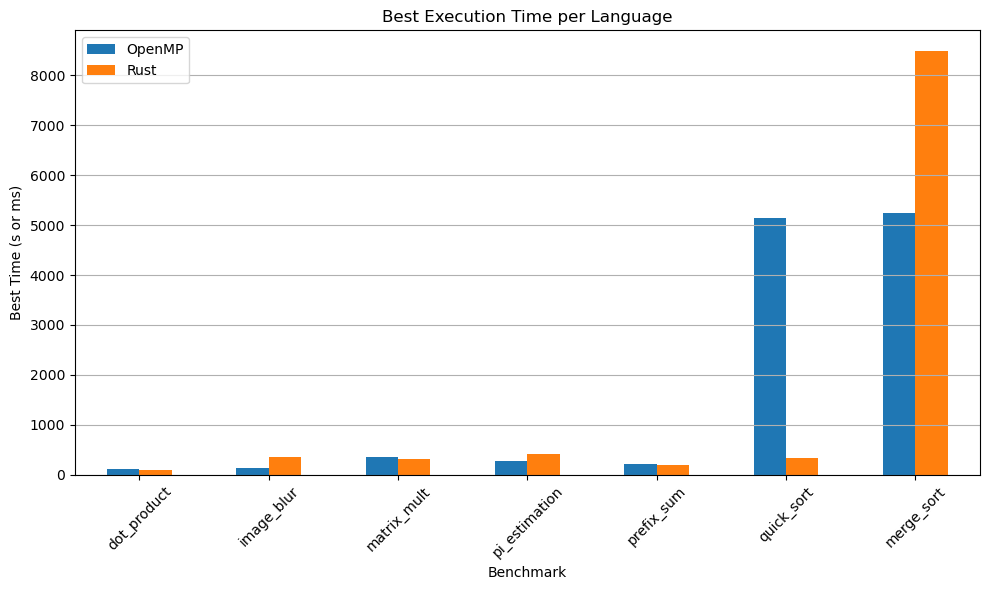

In [7]:
# --- Bar chart of best times ---
best_times = {
    "Benchmark": [],
    "OpenMP": [],
    "Rust": []
}

for name in benchmark_names:
    if name in openmp_results and name in rust_results:
        best_times["Benchmark"].append(name)
        best_times["OpenMP"].append(min(openmp_results[name].iloc[:, 1]))
        best_times["Rust"].append(min(rust_results[name].iloc[:, 1]))

df_best = pd.DataFrame(best_times)

# Bar chart
df_best.set_index("Benchmark").plot(kind='bar', figsize=(10, 6))
plt.ylabel("Best Time (s or ms)")
plt.title("Best Execution Time per Language")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 3. Compute Speedup
- Add new columns for speedup
- Plot speedup vs threads

In [8]:
# Add speedup and efficiency columns
for name in benchmark_names:
    if name in openmp_results and name in rust_results:
        # OpenMP
        omp_df = openmp_results[name].copy()
        omp_baseline = omp_df.iloc[0, 1]  # 1-thread time
        omp_df["Speedup"] = omp_baseline / omp_df.iloc[:, 1]
        omp_df["Efficiency"] = omp_df["Speedup"] / omp_df["Threads"]
        openmp_results[name] = omp_df

        # Rust
        rust_df = rust_results[name].copy()
        rust_baseline = rust_df.iloc[0, 1]
        rust_df["Speedup"] = rust_baseline / rust_df.iloc[:, 1]
        rust_df["Efficiency"] = rust_df["Speedup"] / rust_df["Threads"]
        rust_results[name] = rust_df

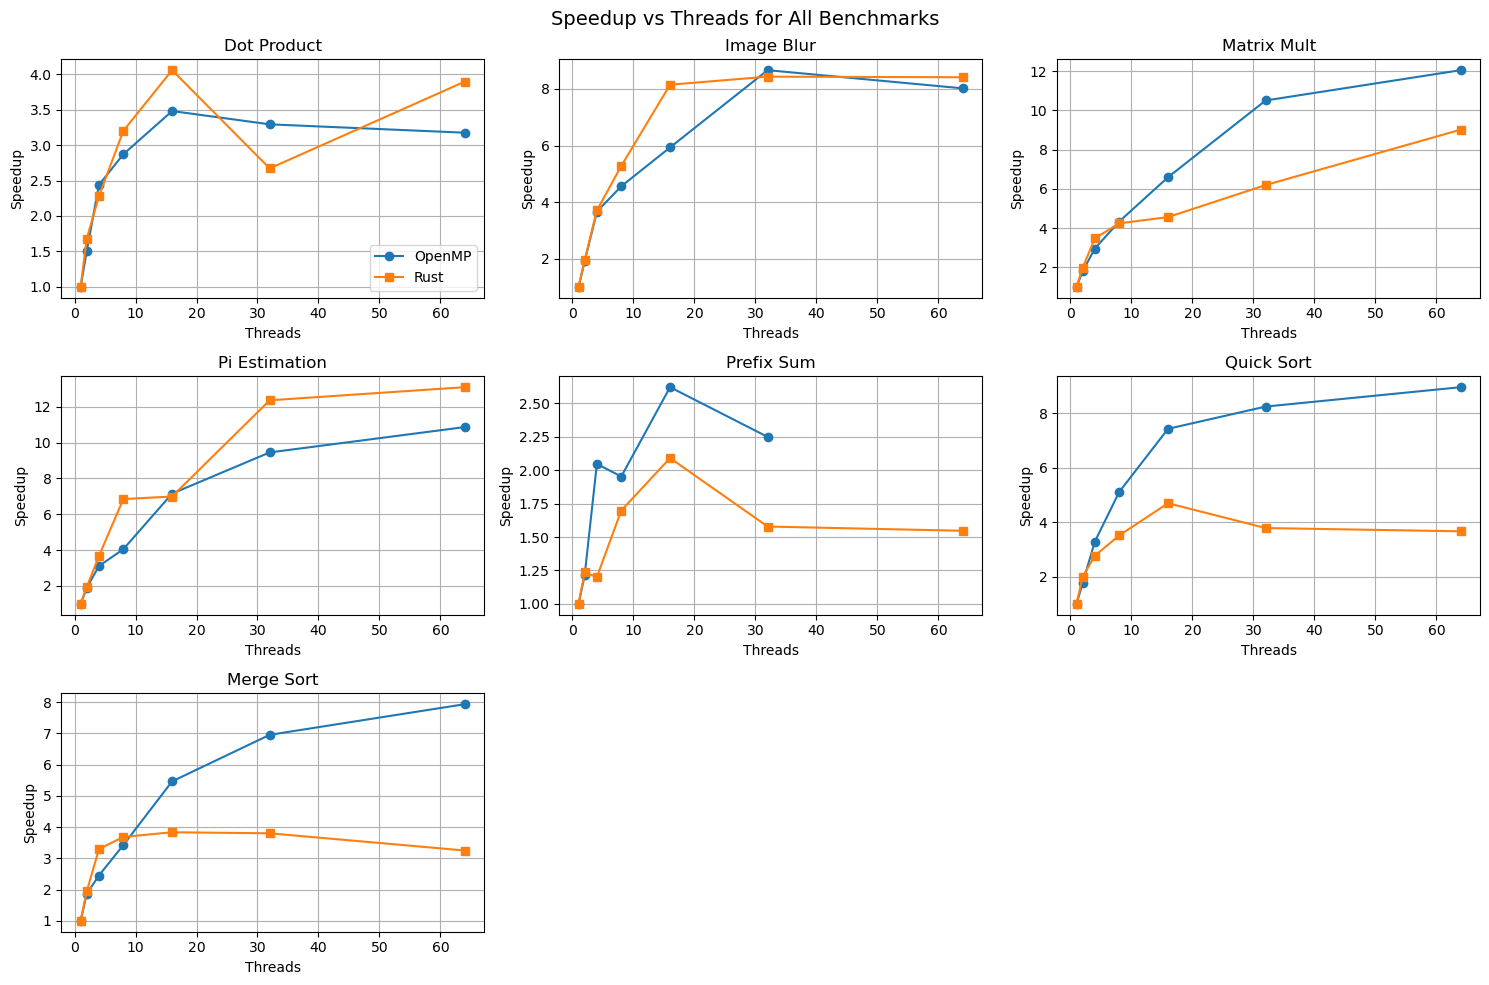

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, name in enumerate(benchmark_names):
    if name in openmp_results and name in rust_results:
        omp_df = openmp_results[name]
        rust_df = rust_results[name]

        axes[i].plot(omp_df["Threads"], omp_df["Speedup"], label="OpenMP", marker="o")
        axes[i].plot(rust_df["Threads"], rust_df["Speedup"], label="Rust", marker="s")
        axes[i].set_title(name.replace("_", " ").title())
        axes[i].set_xlabel("Threads")
        axes[i].set_ylabel("Speedup")
        axes[i].grid(True)

# Hide extra subplot if < 9 benchmarks
for j in range(len(benchmark_names), 9):
    fig.delaxes(axes[j])

axes[0].legend()
fig.suptitle("Speedup vs Threads for All Benchmarks", fontsize=14)
plt.tight_layout()
plt.show()


## 4. Curve Fit & Scalability
- Fit T(1)/T(p) to Amdahl’s Law curve
- goodness-of-fit score

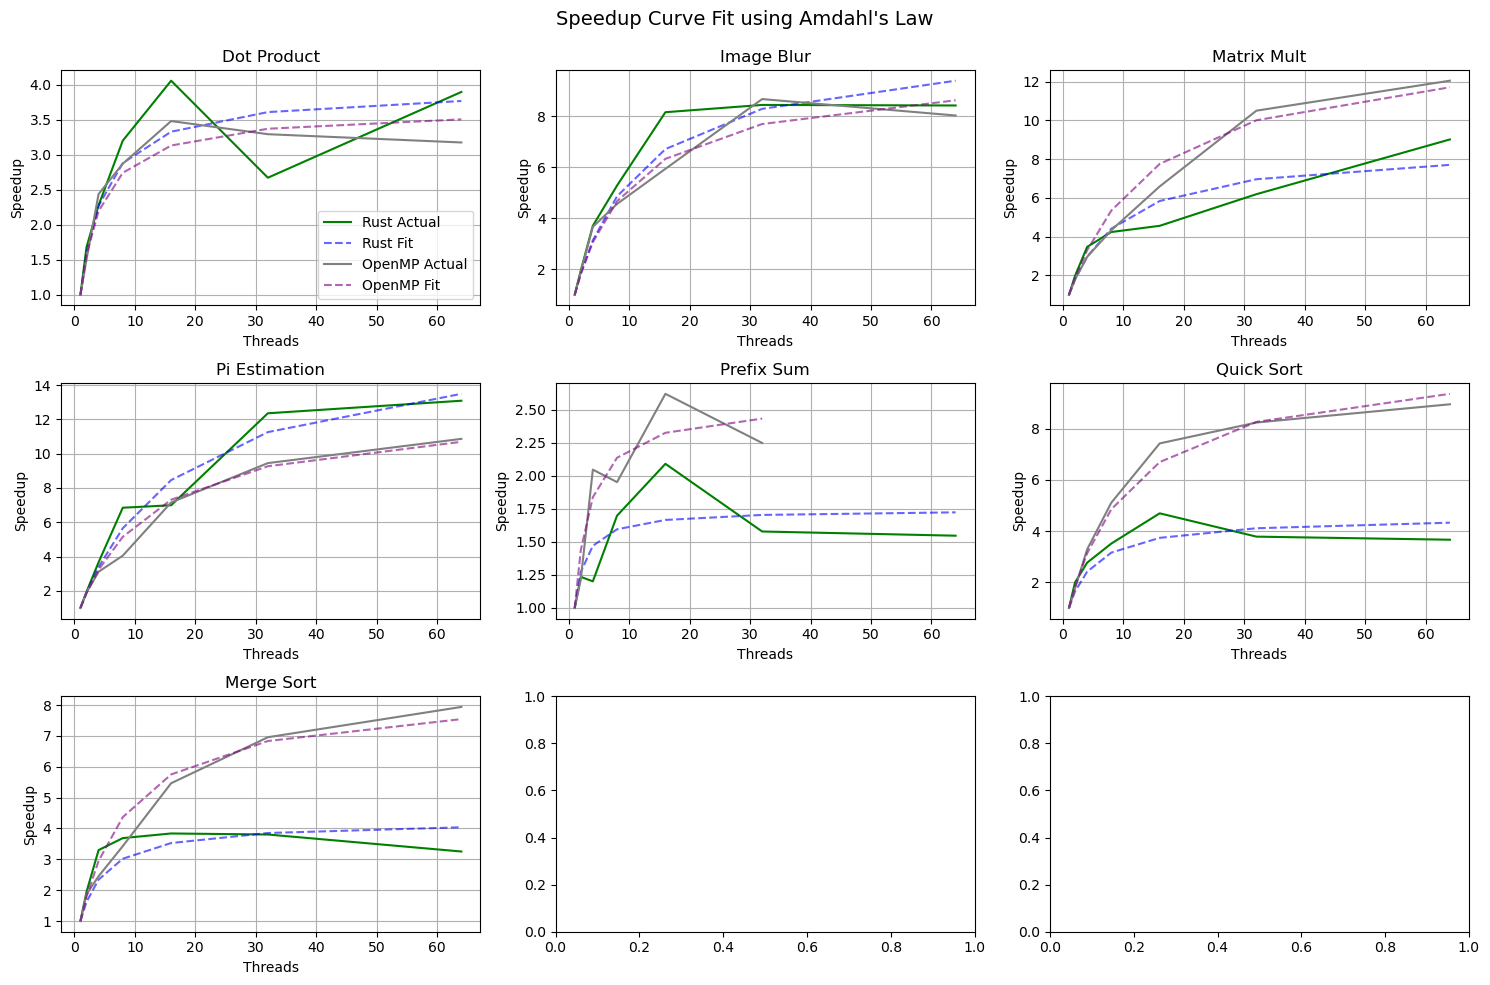

In [10]:
# Define Amdahl's Law for speedup
def amdahl_speedup(p, alpha):
    return 1 / (alpha + (1 - alpha) / p)

# Fit and plot Amdahl's Law for both OpenMP and Rust speedups
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
axs = axs.flatten()

for idx, name in enumerate(benchmark_names):
    if name not in openmp_results or name not in rust_results:
        continue

    omp_df = openmp_results[name]
    rust_df = rust_results[name]

    # Threads and time
    omp_threads, omp_time = omp_df.iloc[:, 0].values, omp_df.iloc[:, 1].values
    rust_threads, rust_time = rust_df.iloc[:, 0].values, rust_df.iloc[:, 1].values

    # Normalize to 1-thread time to compute speedup
    omp_speedup = omp_time[0] / omp_time
    rust_speedup = rust_time[0] / rust_time

    # Fit Amdahl's law
    omp_alpha, _ = curve_fit(amdahl_speedup, omp_threads, omp_speedup, bounds=(0, 1))
    rust_alpha, _ = curve_fit(amdahl_speedup, rust_threads, rust_speedup, bounds=(0, 1))

    # Generate fitted curves
    omp_fit = amdahl_speedup(omp_threads, omp_alpha[0])
    rust_fit = amdahl_speedup(rust_threads, rust_alpha[0])

    ax = axs[idx]
    ax.plot(rust_threads, rust_speedup, label="Rust Actual", color="green")
    ax.plot(rust_threads, rust_fit, linestyle="--", label="Rust Fit", color="blue", alpha=0.6)

    ax.plot(omp_threads, omp_speedup, label="OpenMP Actual", color="gray")
    ax.plot(omp_threads, omp_fit, linestyle="--", label="OpenMP Fit", color="purple", alpha=0.6)

    ax.set_title(name.replace("_", " ").title())
    ax.set_xlabel("Threads")
    ax.set_ylabel("Speedup")
    ax.grid(True)

axs[0].legend()
plt.suptitle("Speedup Curve Fit using Amdahl's Law", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [11]:
# Compute Scalability Score (max speedup / threads at max)
scalability_scores = {
    "Benchmark": [],
    "OpenMP": [],
    "Rust": []
}

for name in benchmark_names:
    if name in openmp_results and name in rust_results:
        omp_df = openmp_results[name]
        rust_df = rust_results[name]

        # OpenMP score
        omp_max_idx = omp_df["Speedup"].idxmax()
        omp_max_speedup = omp_df.loc[omp_max_idx, "Speedup"]
        omp_threads_at_max = omp_df.loc[omp_max_idx, "Threads"]
        omp_score = omp_max_speedup / omp_threads_at_max

        # Rust score
        rust_max_idx = rust_df["Speedup"].idxmax()
        rust_max_speedup = rust_df.loc[rust_max_idx, "Speedup"]
        rust_threads_at_max = rust_df.loc[rust_max_idx, "Threads"]
        rust_score = rust_max_speedup / rust_threads_at_max

        # Save to results
        scalability_scores["Benchmark"].append(name)
        scalability_scores["OpenMP"].append(omp_score)
        scalability_scores["Rust"].append(rust_score)

# Turn into DataFrame for easy display or plotting
df_scalability = pd.DataFrame(scalability_scores)
display(df_scalability)


,Benchmark,OpenMP,Rust
0,dot_product,0.217485,0.253496
1,image_blur,0.270764,0.263605
2,matrix_mult,0.188306,0.140929
3,pi_estimation,0.169799,0.204593
4,prefix_sum,0.163762,0.130648
5,quick_sort,0.139820,0.293237
6,merge_sort,0.124037,0.239857


## 5. Efficiency
- Add efficiency column to each DataFrame (both OpenMP and Rust).
- Plot Efficiency vs Threads for each benchmark.

In [12]:
# Add Efficiency columns
for name in benchmark_names:
    if name in openmp_results and name in rust_results:
        df_openmp = openmp_results[name]
        df_rust = rust_results[name]

        df_openmp['Efficiency'] = df_openmp['Speedup'] / df_openmp['Threads']
        df_rust['Efficiency'] = df_rust['Speedup'] / df_rust['Threads']

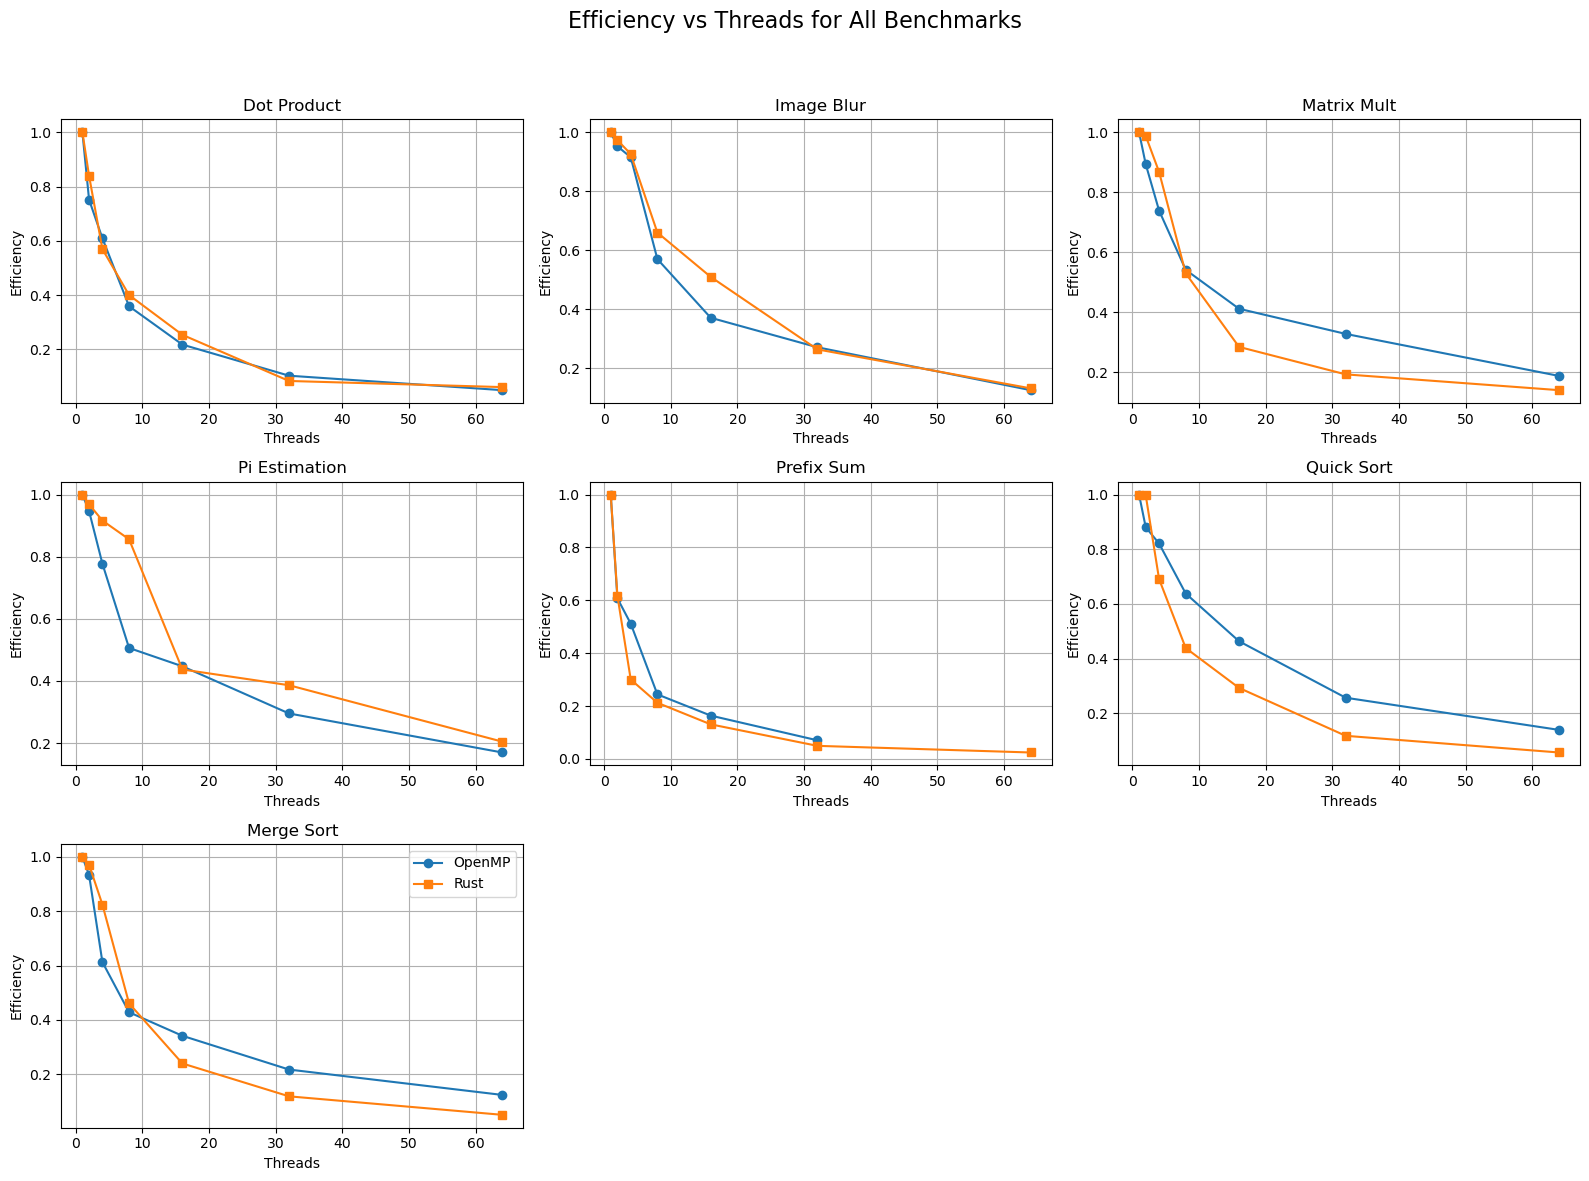

In [13]:
# Plot Efficiency vs Threads (3x3 layout)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
axes = axes.flatten()

for idx, name in enumerate(benchmark_names):
    if name in openmp_results and name in rust_results:
        df_openmp = openmp_results[name]
        df_rust = rust_results[name]

        ax = axes[idx]
        ax.plot(df_openmp['Threads'], df_openmp['Efficiency'], marker='o', label='OpenMP')
        ax.plot(df_rust['Threads'], df_rust['Efficiency'], marker='s', label='Rust')
        ax.set_title(name.replace("_", " ").title())
        ax.set_xlabel("Threads")
        ax.set_ylabel("Efficiency")
        ax.grid(True)
        if name == "merge_sort":
            ax.legend()

# Remove empty subplots
for i in range(len(benchmark_names), len(axes)):
    fig.delaxes(axes[i])

fig.suptitle("Efficiency vs Threads for All Benchmarks", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 6. Rust vs OpenMP Win Count
- for each benchmark, whether Rust or OpenMP had the better best-case time

In [14]:
# Win count tracking
win_counts = {
    "Benchmark": [],
    "Winner": []
}

for name in benchmark_names:
    if name in openmp_results and name in rust_results:
        omp_best = openmp_results[name]["Time (ms)"].min()
        rust_best = rust_results[name]["Time (ms)"].min()
        
        winner = "Rust" if rust_best < omp_best else "OpenMP"
        win_counts["Benchmark"].append(name)
        win_counts["Winner"].append(winner)

df_wins = pd.DataFrame(win_counts)

# Tally wins
win_summary = df_wins["Winner"].value_counts().to_frame(name="Count")
display(df_wins)
display(win_summary)

,Benchmark,Winner
0,dot_product,Rust
1,image_blur,OpenMP
2,matrix_mult,Rust
3,pi_estimation,OpenMP
4,prefix_sum,Rust
5,quick_sort,Rust
6,merge_sort,OpenMP


,Count
Winner,
Rust,4
OpenMP,3


In [15]:
thread_wins = []

for name in benchmark_names:
    if name in openmp_results and name in rust_results:
        omp_df = openmp_results[name]
        rust_df = rust_results[name]

        for t_omp, t_rust, threads in zip(omp_df.iloc[:, 1], rust_df.iloc[:, 1], omp_df["Threads"]):
            if t_omp < t_rust:
                winner = "OpenMP"
            elif t_rust < t_omp:
                winner = "Rust"
            else:
                winner = "Tie"
            thread_wins.append({"Benchmark": name, "Threads": threads, "Winner": winner})

# Convert to DataFrame
df_thread_wins = pd.DataFrame(thread_wins)

# Count wins per language
thread_win_count = df_thread_wins["Winner"].value_counts().reset_index()
thread_win_count.columns = ["Winner", "Count"]
display(df_thread_wins)
display(thread_win_count)

,Benchmark,Threads,Winner
0,dot_product,1,Rust
1,dot_product,2,Rust
2,dot_product,4,OpenMP
3,dot_product,8,Rust
4,dot_product,16,Rust
5,dot_product,32,OpenMP
6,dot_product,64,Rust
7,image_blur,1,OpenMP
8,image_blur,2,OpenMP
9,image_blur,4,OpenMP


,Winner,Count
0,Rust,26
1,OpenMP,22
